<a href="https://colab.research.google.com/github/jmarrietar/ocular/blob/master/notebooks/multitask_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#pip install sklearn

In [1]:
pip install scikit-multilearn

In [3]:
#pip install pandas

In [4]:
#pip install seaborn

In [2]:
from google.colab import auth, drive
from googleapiclient.discovery import build
from googleapiclient.http import MediaFileUpload

In [3]:
# Mount Drive
drive.mount('/content/drive')
auth.authenticate_user()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import h5py
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import sys
import pandas as pd
#sys.path.append("/tf/home/")
#from keras_kfold import kfoldcv
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, recall_score
from sklearn.utils import compute_class_weight
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from sklearn.model_selection import train_test_split


In [5]:
def build_model(n_layers, n_units, activation, lr):
    # Define the model architecture
    model=tf.keras.models.Sequential()
    for layer in range(n_layers):
        if layer == 0:
            model.add(tf.keras.layers.Dense(n_units,activation=activation, input_shape=(1024,)))
            model.add(tf.keras.layers.Dropout(0.2))
        else:
            model.add(tf.keras.layers.Dense(n_units,activation=activation))
        model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(Y_train.shape[1],activation="sigmoid"))
    #model.add(tf.keras.layers.Dense(1,activation="sigmoid"))
    model.compile(loss=lambda y_true,y_pred:weighted_loss(y_true,y_pred,cweights),optimizer=tf.keras.optimizers.Adam(lr=lr))
    #model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(lr=lr))
    return model

params={"n_layers":[1,2,3],"n_units":[128,512,1024], "activation": ["relu", "elu"], "lr":[1e-4,1e-5,1e-6]}


In [6]:
cnn_model_name = "densenet121_CAB_EyePACS"

hdf5_features_kaggle = '/content/drive/MyDrive/Colab Notebooks/Multitask/features/' + '{}_kaggle.hdf5'.format(cnn_model_name)
    
with h5py.File(hdf5_features_kaggle, "r") as f:  
  print(f.keys())
  X_f_train = f["features"][:]
  a_train = f['A'][:].astype('float32')
  h_train = f['H'][:].astype('float32')
  cws_train = f['CWS'][:].astype('float32')
  vb_train = f['VB'][:].astype('float32')
  nv_train = f['NV'][:].astype('float32')
  dr_train = f['Retinopathy'][:].astype('float32')

hdf5_features_messidor = '/content/drive/MyDrive/Colab Notebooks/Multitask/features/' + '{}_messidor2.hdf5'.format(cnn_model_name)

with h5py.File(hdf5_features_messidor, "r") as f:  
  X_test = f["features"][:]
  a_test = f['A'][:].astype('float32')
  h_test = f['H'][:].astype('float32')
  cws_test = f['CWS'][:].astype('float32')
  vb_test = f['VB'][:].astype('float32')
  nv_test = f['NV'][:].astype('float32')
  dr_test = f['Retinopathy'][:].astype('float32')

<KeysViewHDF5 ['A', 'CWS', 'DME', 'H', 'ID', 'NV', 'Referable', 'Retinopathy', 'VB', 'features']>


In [10]:
a_train.shape

(3210,)

In [12]:
dr_train[dr_train>1]

array([2., 2., 2., ..., 3., 4., 3.], dtype=float32)

In [13]:
# DR Referible/ No referible
dr_train[dr_train==1]=0
dr_train[dr_train>1]=1

In [14]:
y_train = np.vstack((a_train, h_train, cws_train, vb_train, nv_train, dr_train)).T
y_test = np.vstack((a_test, h_test, cws_test, vb_test, nv_test, dr_test)).T

In [15]:
#X_train, X_val, Y_train, Y_val=train_test_split(X_f_train, y_train, test_size = 0.3)
X_train, Y_train,  X_val, Y_val= iterative_train_test_split(X_f_train, y_train, test_size = 0.3)

In [16]:
Y_train.shape

(2247, 6)

In [19]:
X_train.shape

(2247, 1024)

In [20]:
X_f_train.shape, dr_train.shape, Y_train.shape, X_train.shape

((3210, 1024), (3210,), (2247, 6), (2247, 1024))

In [ ]:
#X_train, Y_train, X_val, Y_val=iterative_train_test_split(X_train, y_train, test_size = 0.3)

**Build model**

In [21]:
import tensorflow as tf
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

def class_weights(y_true):
    weights = np.empty([y_true.shape[1], 2])
    for i in range(y_true.shape[1]):
        weights[i]=compute_class_weight('balanced', [0.,1.], y_true[:, i])
    return weights
def weighted_loss(y_true, y_pred, weights=None):
    return tf.reduce_mean((weights[:,0]**(1-y_true))*(weights[:,1]**(y_true))*tf.keras.backend.binary_crossentropy(y_true, y_pred), axis=-1)

In [22]:
cweights=class_weights(Y_train)

In [23]:
model=build_model(2, 512, 'elu', 1e-6)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [24]:
class f1_callback(Callback):
    def __init__(self,X_val,Y_val,model_path):
        self.__X_val=X_val
        self.__Y_val=Y_val
        self.__best_auc=0
        self.__model_path=model_path
        
    def on_epoch_end(self, epoch, logs={}):
        pred=np.round(self.model.predict(self.__X_val))

        f1a =f1_score(self.__Y_val[:,0], pred[:,0],average="binary")
        f1h =f1_score(self.__Y_val[:,1], pred[:,1],average="binary")
        f1cw=f1_score(self.__Y_val[:,2], pred[:,2],average="binary")
        f1vb=f1_score(self.__Y_val[:,3], pred[:,3],average="binary")
        f1nv=f1_score(self.__Y_val[:,4], pred[:,4],average="binary")
        f1r =f1_score(self.__Y_val[:,4], pred[:,5],average="binary")
        
        cur_auc=np.mean([f1a,f1h,f1cw,f1vb,f1nv,f1r])
        if cur_auc>=self.__best_auc:
            self.model.save_weights(self.__model_path)
            print("f1_binary improved from {} to {}".format(self.__best_auc,cur_auc))
            self.__best_auc=cur_auc

In [25]:
path="multitask.hdf5"
#checkpoint=ModelCheckpoint(path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks=[f1_callback(X_val,Y_val,path)]


In [26]:
pwd

'/content'

In [ ]:
#class_weights = compute_class_weight('balanced',np.unique(Y_train), Y_train)
#d_class_weights={i:val for i,val in enumerate(class_weights)}

In [27]:
#hist=model.fit(X_train, Y_train, validation_data=(X_val,Y_val), epochs=400, batch_size=1024, verbose=True, class_weight=d_class_weights)
hist=model.fit(X_train, Y_train, validation_data=(X_val,Y_val), epochs=400, batch_size=1024, verbose=True)

Epoch 1/400
3/3 [==============================] - 3s 164ms/step - loss: 0.7024 - val_loss: 0.6467
Epoch 2/400
3/3 [==============================] - 0s 20ms/step - loss: 0.7101 - val_loss: 0.6447
Epoch 3/400
3/3 [==============================] - 0s 19ms/step - loss: 0.7037 - val_loss: 0.6428
Epoch 4/400
3/3 [==============================] - 0s 19ms/step - loss: 0.7036 - val_loss: 0.6410
Epoch 5/400
3/3 [==============================] - 0s 18ms/step - loss: 0.7016 - val_loss: 0.6391
Epoch 6/400
3/3 [==============================] - 0s 17ms/step - loss: 0.6896 - val_loss: 0.6373
Epoch 7/400
3/3 [==============================] - 0s 16ms/step - loss: 0.6986 - val_loss: 0.6356
Epoch 8/400
3/3 [==============================] - 0s 17ms/step - loss: 0.6880 - val_loss: 0.6339
Epoch 9/400
3/3 [==============================] - 0s 18ms/step - loss: 0.6870 - val_loss: 0.6322
Epoch 10/400
3/3 [==============================] - 0s 18ms/step - loss: 0.6886 - val_loss: 0.6306
Epoch 11/400
3/3 [

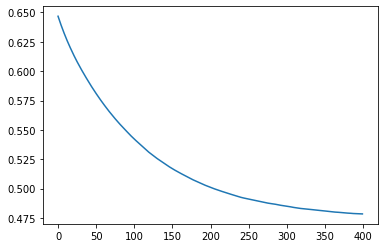

In [28]:
plt.plot(hist.history['val_loss'])

In [29]:
model.save('/content/drive/MyDrive/Colab Notebooks/Multitask/dr_9479.h5')

**Evaluate the model with FON test partition**

In [ ]:
model.load_weights('/content/drive/MyDrive/Colab Notebooks/Multitask/dr_9479.h5')

In [30]:
y_pred=model.predict(X_test)
#y_pred_round=np.round(model.predict(X_test))

In [31]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix

**Aneurisms**

In [35]:
a=np.vstack((y_pred[:,0], y_test[:,0]))

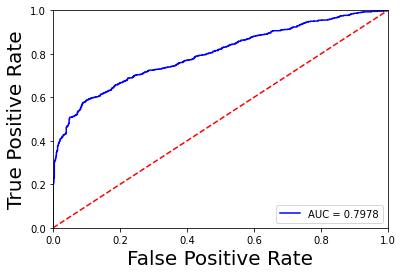

In [41]:
fpr, tpr, threshold=roc_curve(y_test[:,0], y_pred[:,0])
auc=roc_auc_score(y_test[:,0],y_pred[:,0])
#plt.title('Receiver Operating Characteristic', fontsize = 22.0)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', fontsize = 20.0)
plt.xlabel('False Positive Rate', fontsize = 20.0)
plt.show()

**Hemorrhage**

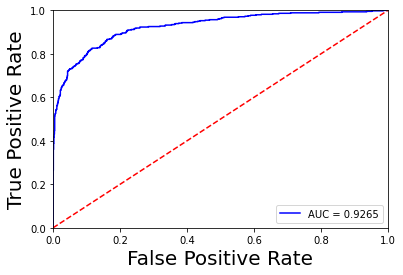

In [42]:
fpr, tpr, threshold=roc_curve(y_test[:,1], y_pred[:,1])
auc=roc_auc_score(y_test[:,1],y_pred[:,1])
#plt.title('Receiver Operating Characteristic', fontsize = 22.0)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', fontsize = 20.0)
plt.xlabel('False Positive Rate', fontsize = 20.0)
plt.show()


**CWS**

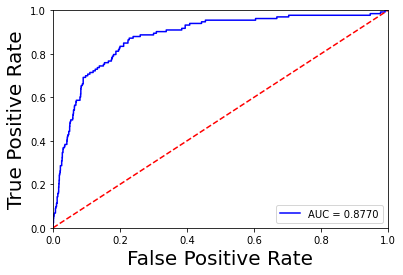

In [43]:
fpr, tpr, threshold=roc_curve(y_test[:,2], y_pred[:,2])
auc=roc_auc_score(y_test[:,2],y_pred[:,2])
#plt.title('Receiver Operating Characteristic', fontsize = 22.0)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', fontsize = 20.0)
plt.xlabel('False Positive Rate', fontsize = 20.0)
plt.show()



**Venous beading**

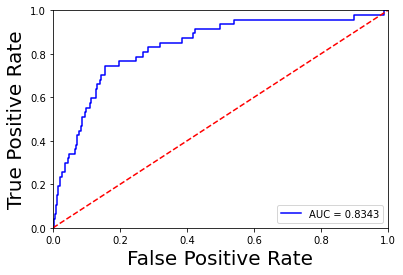

In [44]:
fpr, tpr, threshold=roc_curve(y_test[:,3], y_pred[:,3])
auc=roc_auc_score(y_test[:,3],y_pred[:,3])
#plt.title('Receiver Operating Characteristic', fontsize = 22.0)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', fontsize = 20.0)
plt.xlabel('False Positive Rate', fontsize = 20.0)
plt.show()



**Neovascularization**

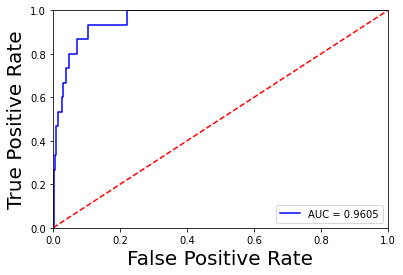

In [45]:
fpr, tpr, threshold=roc_curve(y_test[:,4], y_pred[:,4])
auc=roc_auc_score(y_test[:,4],y_pred[:,4])
#plt.title('Receiver Operating Characteristic', fontsize = 22.0)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', fontsize = 20.0)
plt.xlabel('False Positive Rate', fontsize = 20.0)
plt.show()


**Retinopathy**

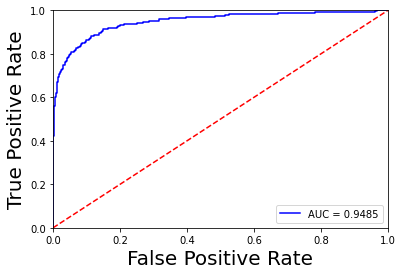

In [46]:
fpr, tpr, threshold=roc_curve(y_test[:,5], y_pred[:,5])
auc=roc_auc_score(y_test[:,5],y_pred[:,5])
#plt.title('Receiver Operating Characteristic', fontsize = 22.0)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', fontsize = 20.0)
plt.xlabel('False Positive Rate', fontsize = 20.0)
plt.show()